In [3]:
import time
import queue
import pandas as pd
import threading
from typing import Union, List
from tqdm import tqdm
from pathlib import Path 
import numpy as np
from datasets import Dataset
from transformers import PreTrainedTokenizerFast
from tokenizers.processors import TemplateProcessing
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)
from tokenizers.models import BPE
from statistics import mean, median
from tokenizers.pre_tokenizers import Digits, Whitespace, Sequence
import matplotlib.pyplot as plt
from Bio.Seq import translate
PathLike = Union[str, Path]
import re
import os
import torch
from utils import any_file_fasta_reader, group_and_contextualize

#from genslm.utils import read_fasta_only_seq, read_fasta, Sequence

# Assign a unique character to each codon so that we can use it as an
# input token to a BPE tokenizer. This implements a codon-pair encoding.
CODON_CHAR = {
    'TCG': "A", 'GCA': "B", 'CTT': "C", 'ATT': "D", 'TTA': "E", 'GGG': "F", 'CGT': "G", 
    'TAA': "H", 'AAA': "I", 'CTC': "J", 'AGT': "K", 'CCA': "L", 'TGT': "M", 'GCC': "N", 
    'GTT': "O", 'ATA': "P", 'TAC': "Q", 'TTT': "R", 'TGC': "S", 'CAC': "T", 'ACG': "U", 
    'CCC': "V", 'ATC': "W", 'CAT': "X", 'AGA': "Y", 'GAG': "Z", 'GTG': "a", 'GGT': "b", 
    'GCT': "c", 'TTC': "d", 'AAC': "e", 'TAT': "f", 'GTA': "g", 'CCG': "h", 'ACA': "i", 
    'CGA': "j", 'TAG': "k", 'CTG': "l", 'GGA': "m", 'ATG': "n", 'TCT': "o", 'CGG': "p", 
    'GAT': "q", 'ACC': "r", 'GAC': "s", 'GTC': "t", 'TGG': "u", 'CCT': "v", 'GAA': "w", 
    'TCA': "x", 'CAA': "y", 'AAT': "z", 'ACT': "0", 'GCG': "1", 'GGC': "2", 'CTA': "3", 
    'AAG': "4", 'AGG': "5", 'CAG': "6", 'AGC': "7", 'CGC': "8", 'TTG': "9", 'TCC': "!", 
    'TGA': "@", 'XXX': "*"
}


def build_tokenizer(
    corpus_iterator,
    vocab_size,
    initial_alphabet: list[str],
    tokenizer_type: str,
    add_bos_eos: bool = True,
    max_length: int = 1024,
    save: bool = False,
    tokenzier_save_name: str = "cpe_tokenizer",
):
    special_tokens = {
        "unk_token": "[UNK]",
        "cls_token": "[CLS]",
        "sep_token": "[SEP]",
        "pad_token": "[PAD]",
        "mask_token": "[MASK]",
        "bos_token": "[BOS]",
        "eos_token": "[EOS]",
    }

    bos_index = 5
    eos_index = 6

    # Define tokenizer
    tokenizer = Tokenizer(BPE(unk_token = special_tokens["unk_token"]))
    
    if tokenizer_type == 'cpe_tokenizer':
        tokenizer.pre_tokenizer = Digits(individual_digits=False)
    
    else:
        tokenizer.pre_tokenizer = Whitespace()

    trainer = trainers.BpeTrainer(
        vocab_size=vocab_size,
        special_tokens=list(special_tokens.values()),
        #initial_alphabet=initial_alphabet
    )

    print("Training tokenizer")

    tokenizer.train_from_iterator(corpus_iterator, trainer=trainer)
    # Add post-processor
    # trim_offsets=True will ignore spaces, false will leave them in
    tokenizer.post_processor = processors.ByteLevel(trim_offsets=True)
    if add_bos_eos:
        tokenizer.post_processor = TemplateProcessing(
            single="[BOS] $A [EOS]",
            special_tokens=[("[BOS]", bos_index), ("[EOS]", eos_index)],
        )

    # Add a decoder
    tokenizer.decoder = decoders.ByteLevel()

    # save the tokenizer
    wrapped_tokenizer = PreTrainedTokenizerFast(
        tokenizer_object=tokenizer, **special_tokens
    )
    if save:
        wrapped_tokenizer.save_pretrained(tokenzier_save_name)
        
    print(f"Returning tokenizer with vocab_size = {tokenizer.get_vocab_size()}")

    return wrapped_tokenizer

# ImportError: cannot import name 'group_and_contextualize_cpe_training' from 'utils' (/home/couchbucks/Documents/saketh/cpe/cpe/utils.py)
def group_and_contextualize_cpe_training(seq: str, k: int = 3):
    return "".join(CODON_CHAR.get(seq[i : i + k]) for i in range(0, len(seq), k))

In [4]:
def plot_vocab_lens(sequence_fasta_file: str, max_vocab_len: int, increment: int, start: int, bpe_tokenizer_type: str):
    """_summary_

    Args:
        sequences [str]: _description_
        max_vocab_len (int): _description_
        increment (int): _description_
        bpe_tokenizer_type (str): choices: ["ape_tokenizer", "cpe_tokenizer", "npe_tokenizer"]
    """
    
    dna_sequences = any_file_fasta_reader(sequence_fasta_file)
    
    
     # data preprocessing dependent on tokenizer_type
    if bpe_tokenizer_type == "ape_tokenizer":
        sequences = [translate(seq.upper()) for seq in dna_sequences]
        initial_alphabet = ['R', 'H', 'K', 'D', 'E', 'S', 'T', 'N', 'Q', 'A', 'V', 'I', 'L', 'M', 'F', 'Y', 'W', 'C', 'G', 'P', '_', 'X']
    
    elif bpe_tokenizer_type == "cpe_tokenizer":
        #print(dna_sequences[0])
        sequences = [group_and_contextualize_cpe_training(seq) for seq in dna_sequences]
        initial_alphabet = list(CODON_CHAR.values())
        
    elif bpe_tokenizer_type == "npe_tokenizer":
        sequences = [seq.upper() for seq in dna_sequences]
        initial_alphabet = ["A", "C", "T", "G"]

    else:
        raise ValueError("Please enter a valid bpe_tokenizer_type :)")


    num_tokens_in_vocab = {}
    per_vocab_in_vocab = {}
    
    for vocab_size in range(start, max_vocab_len, increment):
        # Build the tokenizer
        tokenizer = build_tokenizer(sequences, vocab_size, initial_alphabet, bpe_tokenizer_type)
        
        # List of the number of unique token ids for each tokenized sequence
        unique_lens = []
        
        print(f"Finding lens for {vocab_size}")
        for seq in tqdm(sequences):
            #print(tokenizer.vocab)
            
            tokenized_seq = tokenizer(seq, max_length=1024, padding="max_length", truncation=True, return_tensors="pt")
            # torch.unique finds all the individual tokens we USED to tokenize the sequence
            # len finds how many individual tokens we need to tokenize the sequence
            unique_lens.append(len(torch.unique(tokenized_seq['input_ids'])))
            
            # basic sanity check for right now
            if len(torch.flatten(tokenized_seq['input_ids'])) != 1024:
                raise ValueError("input_ids length mismatch")

        #print(unique_lens)
        
        #print(set(unique_lens))
        
        avg_num_unique_tokens = median(unique_lens)
        
        num_tokens_in_vocab[vocab_size] = avg_num_unique_tokens
        
        
        per_vocab_in_vocab[vocab_size] = avg_num_unique_tokens/len(tokenizer.vocab)
        #print(per_vocab_in_vocab)
        del tokenizer, unique_lens, avg_num_unique_tokens
    
    #fig = plt.figure()
    #ax = fig.add_subplot(111)
    plt.scatter(num_tokens_in_vocab.keys(), num_tokens_in_vocab.values())
    plt.title(bpe_tokenizer_type + " absolute median num unique tokens")
    plt.xlabel("Vocab Size")
    plt.ylabel("Num Unique Tokens Used")
    for xy in zip(num_tokens_in_vocab.keys(), num_tokens_in_vocab.values()):
        plt.annotate('(%.2f, %.2f)' % xy, xy=xy)
    plt.show()
    
    plt.scatter(per_vocab_in_vocab.keys(), per_vocab_in_vocab.values())
    plt.title(bpe_tokenizer_type + " relative median num unique tokens")
    plt.xlabel("Vocab Size")
    plt.ylabel("Percentage of Vocab Size Used")
    for xy in zip(per_vocab_in_vocab.keys(), per_vocab_in_vocab.values()):
        plt.annotate('(%.2f, %.2f)' % xy, xy=xy)
    plt.show()
    
    



Training tokenizer



Returning tokenizer with vocab_size = 1000
Finding lens for 1000


100%|██████████| 36631/36631 [01:16<00:00, 478.46it/s]


Training tokenizer



Returning tokenizer with vocab_size = 1100
Finding lens for 1100


100%|██████████| 36631/36631 [01:17<00:00, 472.70it/s]


Training tokenizer



Returning tokenizer with vocab_size = 1200
Finding lens for 1200


100%|██████████| 36631/36631 [01:16<00:00, 475.93it/s]


Training tokenizer



Returning tokenizer with vocab_size = 1300
Finding lens for 1300


100%|██████████| 36631/36631 [01:18<00:00, 467.45it/s]


Training tokenizer



Returning tokenizer with vocab_size = 1400
Finding lens for 1400


100%|██████████| 36631/36631 [01:18<00:00, 469.54it/s]


Training tokenizer



Returning tokenizer with vocab_size = 1500
Finding lens for 1500


100%|██████████| 36631/36631 [01:14<00:00, 494.06it/s]


Training tokenizer



Returning tokenizer with vocab_size = 1600
Finding lens for 1600


100%|██████████| 36631/36631 [01:15<00:00, 487.74it/s]


Training tokenizer



Returning tokenizer with vocab_size = 1700
Finding lens for 1700


100%|██████████| 36631/36631 [01:14<00:00, 494.07it/s]


Training tokenizer



Returning tokenizer with vocab_size = 1800
Finding lens for 1800


100%|██████████| 36631/36631 [01:12<00:00, 501.85it/s]


Training tokenizer



Returning tokenizer with vocab_size = 1900
Finding lens for 1900


100%|██████████| 36631/36631 [01:10<00:00, 522.41it/s]


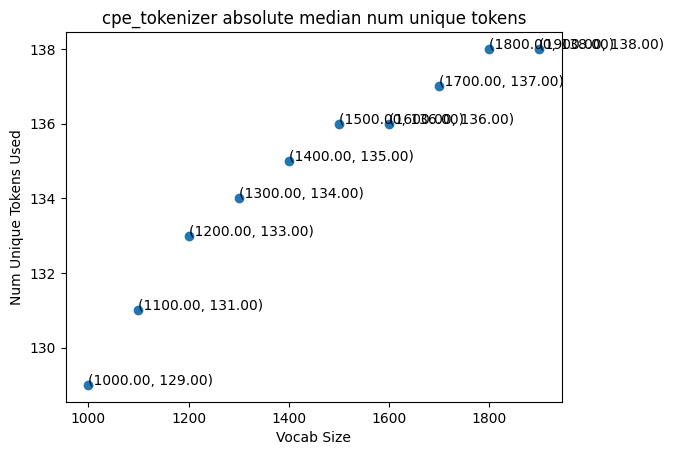

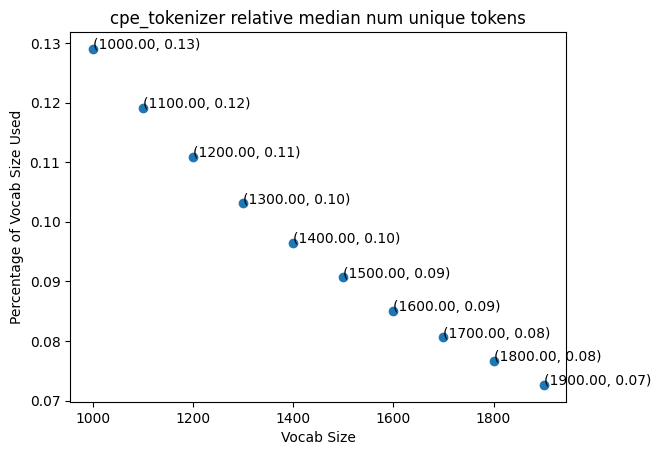

In [7]:
plot_vocab_lens(sequence_fasta_file='/home/couchbucks/Documents/saketh/cpe/datasets/mdh_natural_dataset.fasta', max_vocab_len=2000, increment=100, start = 1000, bpe_tokenizer_type='cpe_tokenizer')